In [1]:
# Importing the packages
import numpy as np
import pytesseract
from PIL import Image
import cv2
import re
import matplotlib.pyplot as plt
from tqdm import tqdm as tq
from transformers import AutoModelWithLMHead, AutoTokenizer , AutoModelForQuestionAnswering
import torch
import tensorflow
from transformers import pipeline
import warnings
from pytesseract import Output
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import spacy
from skimage.filters import threshold_local
import numpy as np
import cv2
from skimage import filters
from skimage.morphology import disk #needed for the mask
warnings.filterwarnings("ignore")

# First Few things to run in file

# Making Functions

In [2]:
%%time
# Importing the model
if torch.cuda.is_available() :
    device=0
else:
    device=-1
model = AutoModelForQuestionAnswering.from_pretrained("../input/question-answering-model/Question_Answering_Model")
tokenizer = AutoTokenizer.from_pretrained("../input/question-answering-model/Question_Answering_Model")
question_model = pipeline("question-answering",use_fast=True,model=model,tokenizer=tokenizer,device=device)# Making a list of questions related to the dataset
# Text summarizar model and tokenizer
model=AutoModelWithLMHead.from_pretrained('../input/summarization-model-4/Text Summarizer')
tokenizer=AutoTokenizer.from_pretrained('../input/summarization-model-4/Text Summarizer')
summarizer=pipeline('summarization',model=model,tokenizer=tokenizer,device=device)

CPU times: user 20.2 s, sys: 3.02 s, total: 23.3 s
Wall time: 43.8 s


In [3]:
##### Importing the text image and showing it using matplotlib
def read_image(path,auto_rotate=True,show_image=False,scan=False):
    text=cv2.imread(path)
    text=cv2.cvtColor(text,cv2.COLOR_BGR2RGB)
    if auto_rotate:
        newdata=pytesseract.image_to_osd(text,output_type=pytesseract.Output.DICT)
        if newdata['rotate']==90 :
            text = cv2.rotate(text, cv2.cv2.ROTATE_90_CLOCKWISE)
        elif newdata['rotate']==180:
            text=cv2.rotate(text,cv2.cv2.ROTATE_180)
        elif newdata['rotate']==270:
            text = cv2.rotate(text, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
    if show_image:
        plt.imshow(text)
        
    if scan :
        mask = np.zeros([text.shape[0],text.shape[1],1],dtype=np.uint8)
        text=cv2.cvtColor(text,cv2.COLOR_BGR2GRAY)
        text = cv2.medianBlur(text,5)
        text = cv2.adaptiveThreshold(text,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
        text = filters.rank.median(text, disk(3))
        cnts = cv2.findContours(text, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cv2.fillPoly(mask, cnts, [255,255,255])
        mask = 255 - mask
        text = cv2.bitwise_or(text, mask)
        element = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
        text = cv2.erode(text, element, iterations = 1)
        text = cv2.dilate(text, element, iterations = 1)
        text = cv2.erode(text, element)
    return text

In [4]:
def autocropping_text(text,padding_size=20,show_image=False,image_name="Image"):
    # Autocropping the image using pytesseract as well
    d = pytesseract.image_to_data(text, output_type=Output.DICT)

    # Working on the left point first
    left=d['left']
    left.sort()
    left=[i for i in left if i!=0]
    if min(left)>padding_size:
        lef=min(left)-padding_size
    else:
        lef=0

    # Working on the right point
    right=d['left']+d['width']
    right.sort(reverse=True)
    right=[i for i in right if i!=text.shape[1]]
    if max(right)+padding_size<text.shape[1]:
        righ=max(right)+padding_size
    else:
        righ=text.shape[1]

    #Working on the top
    top=d['top']
    top.sort()
    top=[i for i in top if i!=0]
    to=min(top)
    if to-padding_size >0 :
        to=to-padding_size
    else:
        to=0

    # Working with bottom
    bottom=d['top']+d['height']
    bottom.sort(reverse=True)
    bottom=[i for i in bottom if i!=text.shape[0]]
    bot=max(bottom)
    if bot+padding_size<text.shape[0]:
        bot=bot+padding_size
    else:
        bot=text.shape[0]

    # Cropping the image now
    crop_img = text[to:bot, lef:righ-20]

    # Showing the image now
    if show_image:
        plt.figure(figsize=(18,8))
        plt.imshow(crop_img)
    
    # Saving the image for future reference 
    cv2.imwrite(image_name+".jpg",crop_img)
    
    # Returing the image
    return crop_img

In [38]:
# Function to translate 
def translate(tex,lang1="English",lang2="Hindi"):
    path='../input/english-to-hindi-model/'+lang1+'_to_'+lang2
    model = AutoModelWithLMHead.from_pretrained(path)
    tokenizer = AutoTokenizer.from_pretrained(path)
    l1=lang1.lower()[:2]
    l2=lang2.lower()[:2]
    translation_path="translation_"+l1+"_to_"+l2
    translate=pipeline(translation_path,model=model,tokenizer=tokenizer,device=device)
    texing=tex.split('.')
    tex_total=[]
    for i in tq(texing) :
        trans=translate(i, max_length=80)[0]['translation_text']
        if '\n' in i :
            coun=i.count("\n")
            st=[trans[int(j*len(trans)/(coun+1)):int((j+1)*len(trans)/(coun+1))] for j in range(coun+1)]
            tex_total.append('\n'.join(st))
        elif i=="" :
            tex_total.append("\n")
        else :
            tex_total.append(trans)
    return('.'.join(tex_total))

In [6]:
def question(tex,questions) :
    answer=question_model(context=tex,question=questions,max_ans_length=12)
    return answer['answer']

In [7]:
def summarize(tex,min_length=5,max_length=50):
    return summarizer(tex, min_length=min_length, max_length=max_length)[0]['summary_text']

In [8]:
def get_font_size(tex):
    l=len(tex.split('\n'))
    

In [9]:
# This is a function for the new template that we have made hopefully this works to the fullest
def function_for_template(tex) :
    tex_frame=tex.split('\n')
    lines=len(tex_frame)
    if lines%5==0 :
        pass
    else:
        lines=round(lines/10)*10
    font_size=int(1+(90-lines)/5)
    # Making the word dictionary 
    word_shape={}
    cc=66
    for i in range(14,0,-1):
        word_shape[i]=cc
        cc+=6
    new_text=[]
    for i in tex_frame :
        x=i
        if len(i)>word_shape[font_size] :
            while len(x)>word_shape[font_size] :
                print(len(x))
                new_text.append(x[:word_shape[font_size]])
                x=x[word_shape[font_size]:]
            new_text.append(x)
        else:
            new_text.append(i)
    lines=len(new_text)
    if lines%5==0 :
        pass
    else:
        lines=round(lines/10)*10
    font_size=int(1+(90-lines)/5)
    # print(tex)
    back=cv2.imread("../input/background-image-20/blank-pages.jpg.webp")
    back=cv2.cvtColor(back,cv2.COLOR_BGR2RGB)
    img = Image.fromarray(back)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('../input/font-2/NexaRustSans-Black.otf', font_size)
    draw.text((124, 24), '\n'.join(new_text), (0, 0, 0), font=font , spacing=1)
    img.save("output_image.jpg")
    imagii=np.array(img)
    return imagii

In [50]:
# Function for template 2
def function_for_old_page(tex,save_format='.jpg'):
    tex_max=tex.split('\n')
    lines=len(tex_max)
    if lines%5==0 :
        pass
    else:
        lines=round(lines/10)*10
    font_size=int(1+(110-lines)/5)
    # Making the word dictionary 
    word_shape={}
    cc=0
    for i in range(24,0,-1):
        word_shape[i]=cc
        cc+=5
    new_text=[]
    for i in tex_max :
        x=i
        if len(i)>word_shape[font_size] :
            while len(x)>word_shape[font_size] :
                new_text.append(x[:word_shape[font_size]])
                x=x[word_shape[font_size]:]
            new_text.append(x)
        else:
            new_text.append(i)
    lines=len(new_text)
    if lines%5==0 :
        pass
    else:
        lines=round(lines/10)*10
    font_size=int(1+(110-lines)/5)
    back=cv2.imread("../input/old-paper/old-paper-blank-page-492408.jpg")
    back=cv2.cvtColor(back,cv2.COLOR_BGR2RGB)
    img = Image.fromarray(back)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('../input/font-2/NexaRustSans-Black.otf', font_size)
    draw.text((50, 76), '\n'.join(new_text), (0, 0, 0), font=font , spacing=1)
    img.save("output_image_old_page+"+save_format)
    imagii=np.array(img)
    return imagii

# Using Functions

# Changes to be made :
Make the font size dynamic so the text can fit
Make the space increase as per the max length to be added in the data

CPU times: user 6.76 s, sys: 182 ms, total: 6.94 s
Wall time: 16.5 s


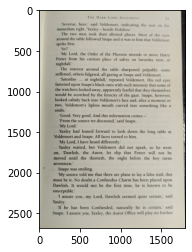

In [11]:
%%time
scanned_image=read_image("../input/textimage/IMG_20210125_155407__01.png",scan=True)
text=read_image("../input/textimage/IMG_20210125_155407__01.png",scan=False)
tex=pytesseract.image_to_string(text)
plt.imshow(text)

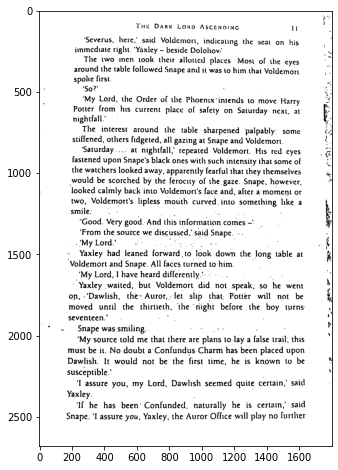

In [12]:
# Having a look at the scanned image
plt.figure(figsize=(18,8))
plt.imshow(scanned_image,cmap='gray')

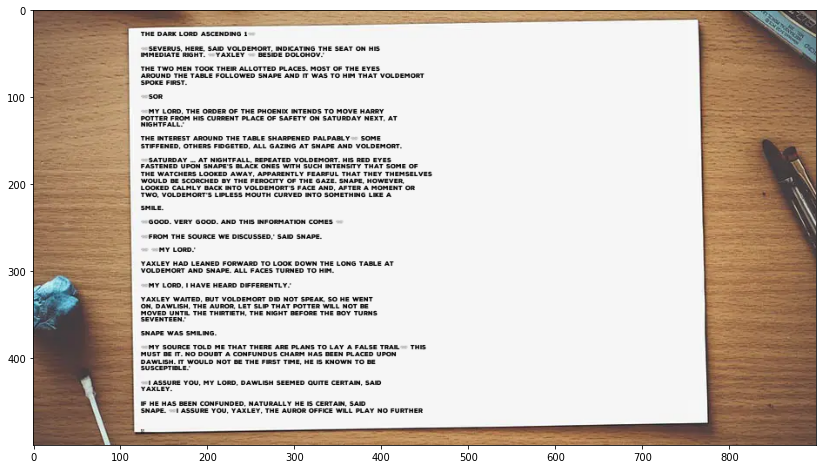

In [13]:
im2=function_for_template(tex)
plt.figure(figsize=(18,8))
plt.imshow(im2)

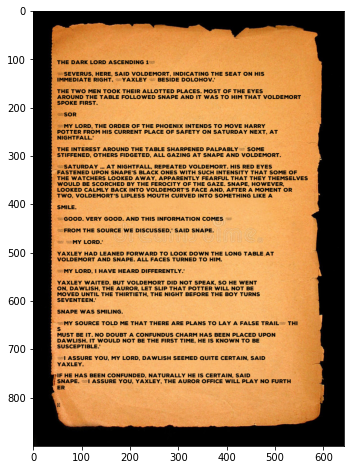

In [14]:
ff=function_for_old_page(tex)
plt.figure(figsize=(18,8))
plt.imshow(ff)

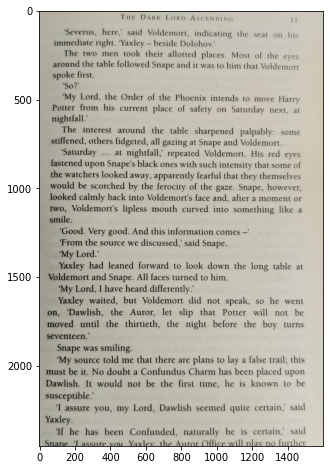

In [15]:
# Autocropping the image
plt.imshow(autocropping_text(text,20,show_image=True))

In [39]:
translation_text=translate(tex,"English","French")

100%|██████████| 27/27 [00:06<00:00,  4.29it/s]


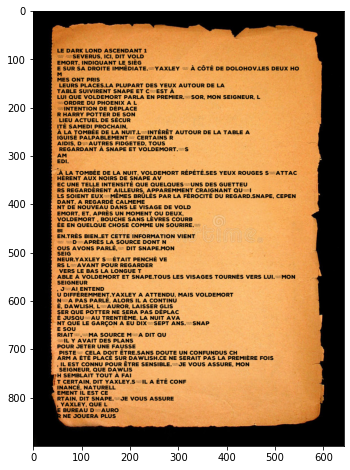

In [49]:
ff=function_for_old_page(translation_text)
plt.figure(figsize=(18,8))
plt.imshow(ff)

In [17]:
question(tex,"who is harry?")

'Harry\nPotter'

In [18]:
summarize(tex,max_length=50)

" Voldemort and Snape sat at the same table at Voldemort's request to discuss Harry Potter's whereabouts . Voldemort's red eyes looked at Snape with such intensity that some of the watchers looked away, apparently fearful that they themselves would be scorched"